## <a name="0">Diabetes Classification using SVM, Logistic Regression and KNN</a>

1. <a href="#1">Problem Statement</a>
2. <a href="#2">Data Exploration</a>
3. <a href="#3">Data Processing</a>
4. <a href="#4">Feature selection</a>
5. <a href="#5">Model Training</a>
6. <a href="#6">Improvements</a>

---
## 1. <a name="1">Problem Statement</a>
(<a href="#0">Go to top</a>)
* Can you build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?
* Unbalanced Data.

### Data fields

* Pregnancies : Number of times pregnant
* Glucose : Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure : Diastolic blood pressure (mm Hg)
* SkinThickness : Triceps skin fold thickness (mm)
* Insulin : 2-Hour serum insulin (mu U/ml)
* BMI : Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction : Diabetes pedigree function
* Age : Age (years)
* Outcome : Class variable (0 or 1) 268 of 768 are 1, the others are 0

### Imports

In [1]:
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
#
from sklearn.metrics import classification_report
from sklearn.metrics import  precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score 
from sklearn.metrics import plot_roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
#---------- configs
pd.set_option('max_rows',100)
pd.set_option('max_columns',100)

In [3]:
### loading data
df_train = pd.read_csv(r"../input/pima-indians-diabetes-database/diabetes.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* No missing values ! , all datatypes are numeric lets check the data

---
## 2. <a name="2">Data Exploration</a>
(<a href="#0">Go to top</a>)

In [4]:
df_copy = df_train.copy()

---
#### Univariate Exploration

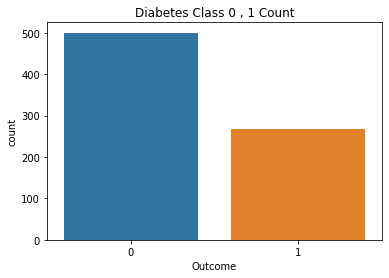

In [5]:
sns.countplot(data = df_copy,x='Outcome')
plt.title('Diabetes Class 0 , 1 Count')
plt.show()

* outcome is not balanced

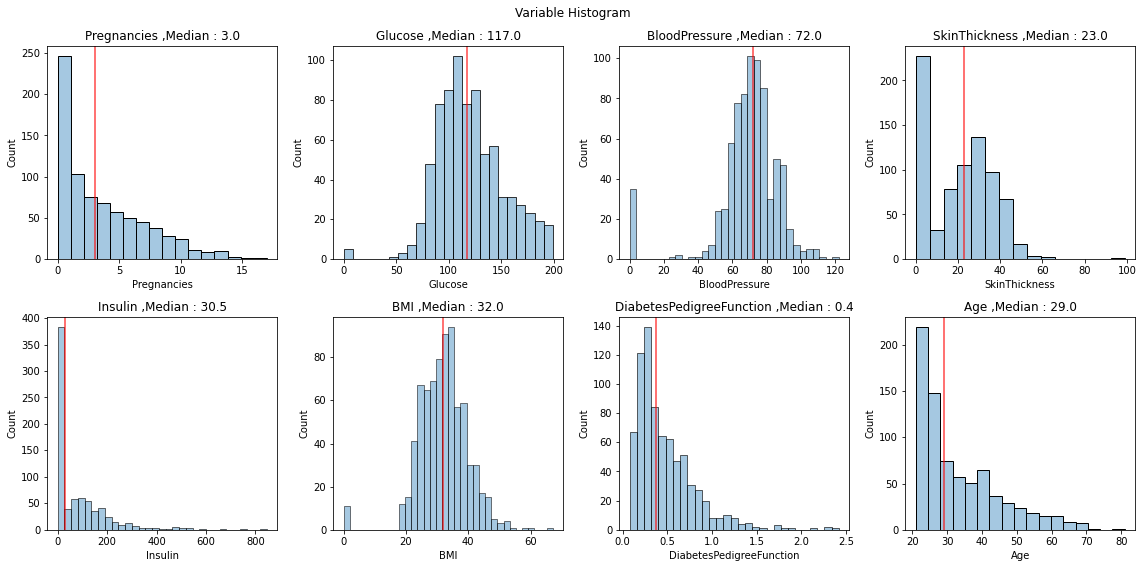

In [6]:
numerical_columns = list(df_copy.select_dtypes(exclude=['object']).columns)

def plot_numerical_histogram(df,x_cols=[],rows = 2,cell_size = 4):
    size = len(x_cols)
    cols = size // rows
    fig,axes = plt.subplots(rows,cols,figsize=(cols * cell_size, rows * cell_size))
    fig.suptitle("Variable Histogram")
    for i,axe in enumerate(axes.flatten()):
        if(i < size):
            sns.histplot(df[x_cols[i]],ax=axe,alpha=0.4)
            median = df[x_cols[i]].median()
            axe.set_title(x_cols[i] + f' ,Median : {median:0.1f}')
            axe.axvline(median, color ='red',lw=2, alpha = 0.55)
        else:
            print('subplots > n of columns, change n of rows')
            break 
    plt.tight_layout()
    plt.show()
plot_numerical_histogram(df_copy,numerical_columns,rows=2)

* some notes 
    * 0 glucose level , 0 blood pressure ,0 BMI , 0 Insulin , 0 SkinThickness
* skin thickness : Its thickness gives information about the fat reserves of the body. ~
    * ref : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5083983/
    * reflects the fat , maybe correlated to bmi 
    * ranges for women according to the ref , ~[10-60]
* most of the distributions are right skewed.

---
#### Bivariate Exploration

* Get Correlated Variables

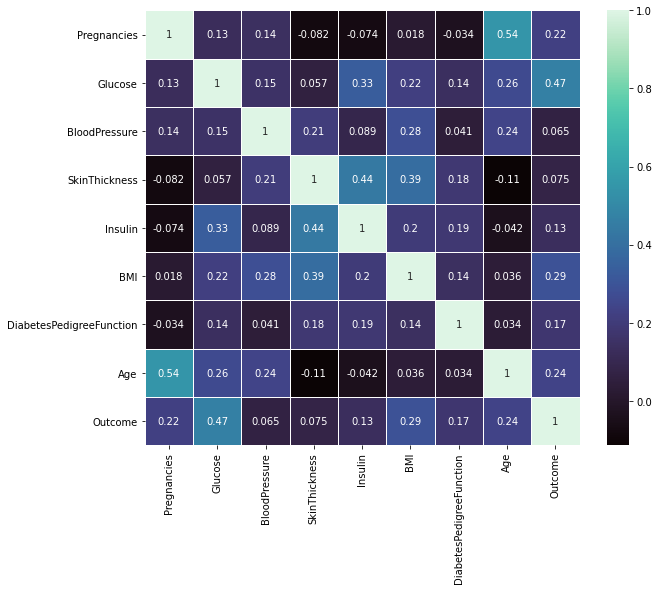

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df_copy.corr(),annot=True,square=True,linewidths=1,cmap='mako',cbar=True)
plt.show()

* notable correlations:
    * Pregnancies and Age
    * Glucose and Insulin
    * Skin Thickness and Insulin , BMI
    

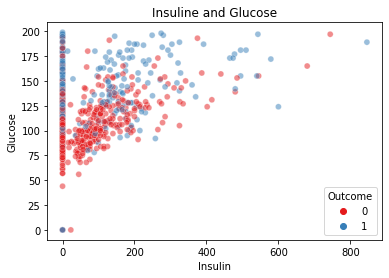

In [8]:
sns.scatterplot(data=df_copy,x='Insulin',y='Glucose',hue='Outcome',palette='Set1',alpha=0.5,x_jitter=0.2,y_jitter=0.3)
plt.title('Insuline and Glucose')
plt.show()

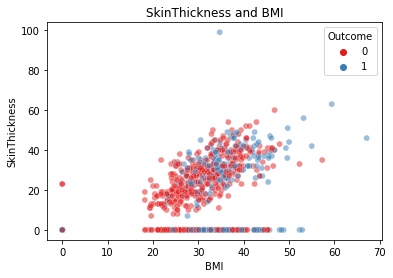

In [9]:
sns.scatterplot(data=df_copy,x='BMI',y='SkinThickness',hue='Outcome',palette='Set1',alpha=0.5)
plt.title('SkinThickness and BMI')
plt.show()

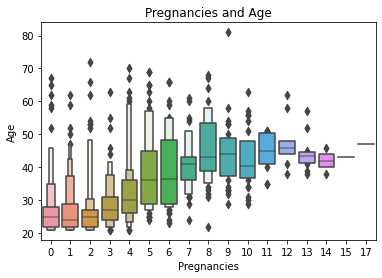

In [10]:
sns.boxenplot(data=df_copy,y='Age',x='Pregnancies')
plt.title('Pregnancies and Age')
plt.show()

---
## 3. <a name="3">Data Processing</a>
(<a href="#0">Go to top</a>)

In [11]:
# split for processing by train information
train,test = train_test_split(df_copy, test_size = 0.2,stratify=df_copy['Outcome'], random_state=47)

* we have to deal with the incorrect data -zeros-
* data skewness.
* data scaling.

In [12]:
def encode_data_series(df_prep,df_original,col_name,from_vals,to_vals):
    df_prep[col_name] = df_original[col_name].replace(from_vals,to_vals,inplace=False)

In [13]:
train_copy = train.copy()
test_copy = test.copy()

In [14]:
incorrect_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']
 
encode_data_series(train_copy,train,incorrect_cols,[0],[np.nan])
encode_data_series(test_copy,test,incorrect_cols,[0],[np.nan])

In [15]:
train_copy.isna().sum()

Pregnancies                   0
Glucose                       4
BloodPressure                27
SkinThickness               179
Insulin                     297
BMI                           7
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

* for low percentage of missing data i will fill by median

In [16]:
low_missing = ['Glucose','BloodPressure','BMI']

for na_col in low_missing:
    encode_data_series(train_copy,train_copy,[na_col],[np.nan],train[na_col].median())
    encode_data_series(test_copy,test_copy,[na_col],[np.nan],train[na_col].median())

In [17]:
train_copy.isna().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               179
Insulin                     297
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [18]:
from sklearn.impute import KNNImputer
kimputer = KNNImputer(n_neighbors=10)
kimputer.fit(train_copy) 
train_imp = kimputer.transform(train_copy)
test_imp = kimputer.transform(test_copy)

In [19]:
train_impA = pd.DataFrame(train_imp,columns = train_copy.columns)
test_impA = pd.DataFrame(test_imp,columns = test_copy.columns)

* lets visualize some of the results

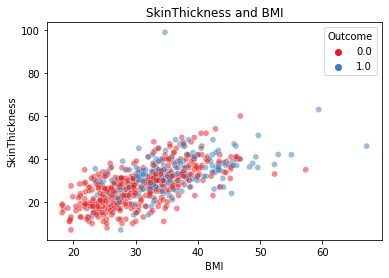

In [20]:
sns.scatterplot(data=train_impA,x='BMI',y='SkinThickness',hue='Outcome',palette='Set1',alpha=0.5)
plt.title('SkinThickness and BMI')
plt.show()

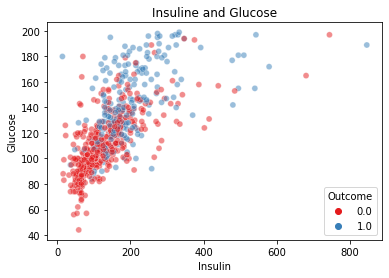

In [21]:
sns.scatterplot(data=train_impA,x='Insulin',y='Glucose',hue='Outcome',palette='Set1',alpha=0.5,x_jitter=0.2,y_jitter=0.3)
plt.title('Insuline and Glucose')
plt.show()

In [22]:
from scipy.stats import skew
#-- skewed data
train_impA_skewed = train_impA.copy()
test_impA_skewed = test_impA.copy()

skewed_feats = train_impA.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

print('Skewed Features : ' ,list(skewed_feats))
train_impA_skewed[skewed_feats] = np.log1p(train_impA[skewed_feats])
test_impA_skewed[skewed_feats] = np.log1p(test_impA[skewed_feats])

Skewed Features :  ['Pregnancies', 'Insulin', 'DiabetesPedigreeFunction', 'Age']


In [23]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()

traintoscale = train_impA_skewed.drop('Outcome',axis=1).copy()
testtoscale = test_impA_skewed.drop('Outcome',axis=1).copy()

s_scaler.fit(traintoscale)
train_scaled = s_scaler.transform(traintoscale)
test_scaled = s_scaler.transform(testtoscale)

train_ready = pd.DataFrame(train_scaled,columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])
test_ready = pd.DataFrame(test_scaled,columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])

train_ready['Outcome'] = train_impA['Outcome']
test_ready['Outcome'] = test_impA['Outcome']

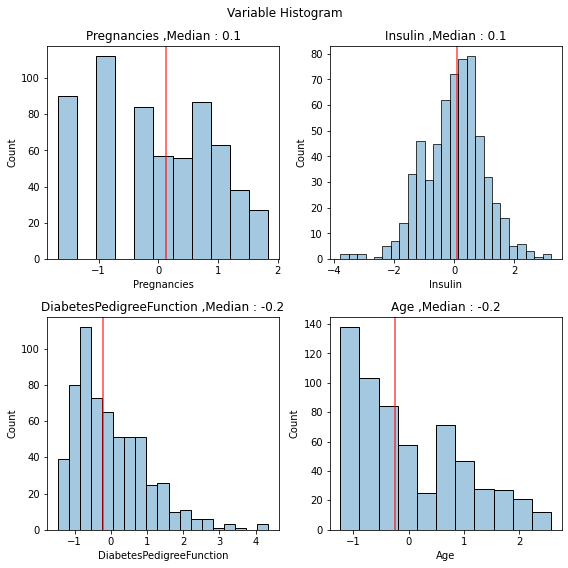

In [24]:
#some distributions after fixing skewness and standardization
plot_numerical_histogram(train_ready,skewed_feats,rows=2)

--- 
## 4. <a name="4">Feature selection</a>
(<a href="#0">Go to top</a>)

In [25]:
df_corr = train_ready.corr()
df_sorted_corr = df_corr['Outcome'].abs().sort_values(ascending=False)[1:]
correlation_threshold =  0.2 
high_corr_cols = df_sorted_corr[df_sorted_corr > correlation_threshold].index.tolist()

In [26]:
print('Sorted Features by Pearson Correlation','\n')
print(df_sorted_corr)

Sorted Features by Pearson Correlation 

Glucose                     0.491573
Insulin                     0.389423
BMI                         0.317813
Age                         0.293499
SkinThickness               0.280585
Pregnancies                 0.181949
DiabetesPedigreeFunction    0.169877
BloodPressure               0.151599
Name: Outcome, dtype: float64


--- 
## 5. <a name="5">Model Training</a>
(<a href="#0">Go to top</a>)

In [27]:
#-- raw data with imbalanced class

# X_train = train_ready[high_corr_cols]
# y_train = train_ready['Outcome']

#-- balancing class distribution in training data only before training
over_smote = SMOTE(sampling_strategy=0.9) # oversampling didn't bring greater results 
under_smote = RandomUnderSampler(sampling_strategy=0.6,random_state=47) #~minimizing the imbalance abit.

X_train, y_train = under_smote.fit_resample(train_ready[high_corr_cols],train_ready['Outcome'])

X_test = test_ready[high_corr_cols]
y_test = test_ready['Outcome']

In [28]:
#original value counts
train_ready['Outcome'].value_counts()

0.0    400
1.0    214
Name: Outcome, dtype: int64

In [29]:
#after smote undersampling
y_train.value_counts()

0.0    356
1.0    214
Name: Outcome, dtype: int64

---
#### KNN Classifier

In [30]:
knn_clf = KNeighborsClassifier()

param_grid = {'n_neighbors' : [i for i in range(1,20) if i%2==0]
              ,'weights':['uniform','distance']}

knn_gcv = GridSearchCV(knn_clf,param_grid,cv=5,scoring='roc_auc')
knn_gcv_fit = knn_gcv.fit(X_train, y_train)

print('best estimator : ',knn_gcv_fit.best_estimator_)
print('best score : ',knn_gcv_fit.best_score_)

best estimator :  KNeighborsClassifier(n_neighbors=18, weights='distance')
best score :  0.8444274172164772


              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80       100
         1.0       0.62      0.67      0.64        54

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.74      0.74       154



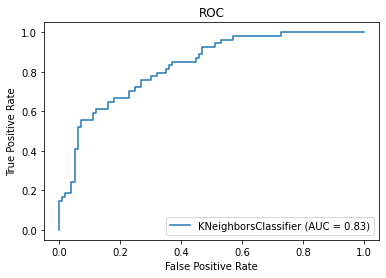

In [31]:
y_eval = knn_gcv_fit.best_estimator_.predict(X_test)
print(classification_report(y_test, y_eval))

plot_roc_curve(knn_gcv_fit.best_estimator_,X_test,y_test)
plt.title('ROC')
plt.show()

---
#### SVC

In [32]:
svc_clf = SVC(class_weight='balanced',random_state=42)

param_grid = {'kernel':['poly', 'rbf'],'degree':[1,2],'C' : np.arange(1,10,1)}

svc_gcv = GridSearchCV(svc_clf,param_grid,cv=5,scoring='roc_auc')
svc_gcv_fit = svc_gcv.fit(X_train, y_train)

print('best estimator : ',svc_gcv_fit.best_estimator_)
print('best score : ',svc_gcv_fit.best_score_)

best estimator :  SVC(C=5, class_weight='balanced', degree=1, random_state=42)
best score :  0.8468507210359487


              precision    recall  f1-score   support

         0.0       0.85      0.71      0.77       100
         1.0       0.59      0.76      0.66        54

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.73       154



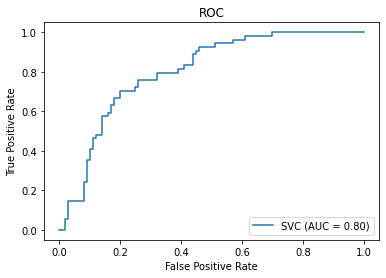

In [33]:
y_eval = svc_gcv_fit.best_estimator_.predict(X_test)
print(classification_report(y_test, y_eval))

plot_roc_curve(svc_gcv_fit.best_estimator_,X_test,y_test)
plt.title('ROC')
plt.show()

---
#### Logisitic Regression

In [34]:
log_clf = LogisticRegression(class_weight='balanced',random_state=42)

param_grid = {'C' :  np.arange(0.01,0.3,0.01)}

log_gcv = GridSearchCV(log_clf,param_grid,cv=5,scoring='roc_auc')
log_gcv_fit = log_gcv.fit(X_train, y_train)

print('best estimator : ',log_gcv_fit.best_estimator_)
print('best score : ',log_gcv_fit.best_score_)


best estimator :  LogisticRegression(C=0.04, class_weight='balanced', random_state=42)
best score :  0.8387118577095649


              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       100
         1.0       0.63      0.69      0.65        54

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



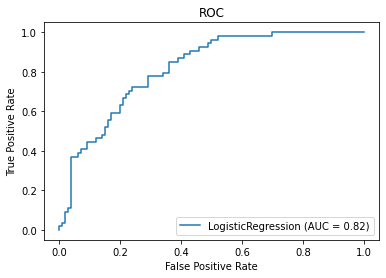

In [35]:
y_eval = log_gcv_fit.best_estimator_.predict(X_test)
print(classification_report(y_test, y_eval))

plot_roc_curve(log_gcv_fit.best_estimator_,X_test,y_test)
plt.title('ROC')
plt.show()

--- 
## 6. <a name="6">Improvements</a>
(<a href="#0">Go to top</a>)

    * Handling outliers.
    * Feature engineering.
    * Interaction between predictors.
    * clustering for uncovering structure in the data.. and much more i may revisit in the future.